In [ ]:
# This mounts your Google Drive to the Colab VM.
try:
  from google.colab import drive # type: ignore
  drive.mount('/content/drive')
except ImportError:
  raise ImportError("WARNING: torch.manual_seed seems to depend the underlying GPU "
                  "which differs from Google Colab. hense, "
                  "YOU WILL GET ERRORS EVEN THE IMPLEMENTATION IS CORRECT.")

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'cs231n/assignment3/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# This downloads the COCO dataset to your Drive
# if it doesn't already exist.
# %cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# # !bash get_datasets.sh
# !bash get_coco_dataset.sh
# %cd /content/drive/My\ Drive/$FOLDERNAME


# Image Captioning with Transformers
You have now implemented a vanilla RNN and for the task of image captioning. In this notebook you will implement key pieces of a transformer decoder to accomplish the same task.

**NOTE:** This notebook will be primarily written in PyTorch rather than NumPy, unlike the RNN notebook.

In [45]:
# Setup cell.
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.transformer_layers import *
from cs231n.captioning_solver_transformer import CaptioningSolverTransformer
from cs231n.classifiers.transformer import CaptioningTransformer
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2


def rel_error(x:np.ndarray, y:np.ndarray):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))
# def rel_error(x, y):
#     """ returns relative error, I changed this from 1e-8 to 1e-2; seems random seed changed a bit.? """
#     out:np.ndarray = ((np.abs(x - y) / (np.abs(x) + np.abs(y))))
#     err = np.mean(out >= 1e-1) # type: ignore
#     warn = np.mean(out >= 1e-2) # type: ignore
#     return format("error: %.3f, warn: %.3f" % (err, warn)) if warn < 0.99 else "All wrong; may also be seed issues instead of implementation error."

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# COCO Dataset
As in the previous notebooks, we will use the COCO dataset for captioning.

In [3]:
# Load COCO data from disk into a dictionary.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary.
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

base dir  /content/drive/MyDrive/cs231n/assignment3/cs231n/datasets/coco_captioning
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


# Transformer
As you have seen, RNNs are incredibly powerful but often slow to train. Further, RNNs struggle to encode long-range dependencies (though LSTMs are one way of mitigating the issue). In 2017, Vaswani et al introduced the Transformer in their paper ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762) to a) introduce parallelism and b) allow models to learn long-range dependencies. The paper not only led to famous models like BERT and GPT in the natural language processing community, but also an explosion of interest across fields, including vision. While here we introduce the model in the context of image captioning, the idea of attention itself is much more general.



# Transformer: Multi-Headed Attention

### Dot-Product Attention

Recall that attention can be viewed as an operation on a query $q\in\mathbb{R}^d$, a set of value vectors $\{v_1,\dots,v_n\}, v_i\in\mathbb{R}^d$, and a set of key vectors $\{k_1,\dots,k_n\}, k_i \in \mathbb{R}^d$, specified as

\begin{align}
c &= \sum_{i=1}^{n} v_i \alpha_i \\
\alpha_i &= \frac{\exp(k_i^\top q)}{\sum_{j=1}^{n} \exp(k_j^\top q)} \\
\end{align}

where $\alpha_i$ are frequently called the "attention weights", and the output $c\in\mathbb{R}^d$ is a correspondingly weighted average over the value vectors.

### Self-Attention
In Transformers, we perform self-attention, which means that the values, keys and query are derived from the input $X \in \mathbb{R}^{\ell \times d}$, where $\ell$ is our sequence length. Specifically, we learn parameter matrices $V,K,Q \in \mathbb{R}^{d\times d}$ to map our input $X$ as follows:

\begin{align}
v_i = Vx_i\ \ i \in \{1,\dots,\ell\}\\
k_i = Kx_i\ \ i \in \{1,\dots,\ell\}\\
q_i = Qx_i\ \ i \in \{1,\dots,\ell\}
\end{align}

### Multi-Headed Scaled Dot-Product Attention
In the case of multi-headed attention, we learn a parameter matrix for each head, which gives the model more expressivity to attend to different parts of the input. Let $h$ be number of heads, and $Y_i$ be the attention output of head $i$. Thus we learn individual matrices $Q_i$, $K_i$ and $V_i$. To keep our overall computation the same as the single-headed case, we choose $Q_i \in \mathbb{R}^{d\times d/h}$, $K_i \in \mathbb{R}^{d\times d/h}$ and $V_i \in \mathbb{R}^{d\times d/h}$. Adding in a scaling term $\frac{1}{\sqrt{d/h}}$ to our simple dot-product attention above, we have

$$  
Y_i = \text{softmax}\bigg(\frac{(XQ_i)(XK_i)^\top}{\sqrt{d/h}}\bigg)(XV_i)

$$

where $Y_i\in\mathbb{R}^{\ell \times d/h}$, where $\ell$ is our sequence length.

In our implementation, we apply dropout to the attention weights (though in practice it could be used at any step):

$$  
Y_i = \text{dropout}\bigg(\text{softmax}\bigg(\frac{(XQ_i)(XK_i)^\top}{\sqrt{d/h}}\bigg)\bigg)(XV_i)

$$

Finally, then the output of the self-attention is a linear transformation of the concatenation of the heads:

$$  
Y = [Y_1;\dots;Y_h]A
$$

were $A \in\mathbb{R}^{d\times d}$ and $[Y_1;\dots;Y_h]\in\mathbb{R}^{\ell \times d}$.

Implement multi-headed scaled dot-product attention in the `MultiHeadAttention` class in the file `cs231n/transformer_layers.py`. The code below will check your implementation. The relative error should be less than `e-3`.

In [7]:
torch.manual_seed(231)

# Choose dimensions such that they are all unique for easier debugging:
# Specifically, the following values correspond to N=1, H=2, T=3, E//H=4, and E=8.
batch_size = 1
sequence_length = 3
embed_dim = 8
attn = MultiHeadAttention(embed_dim, num_heads=2)

# Self-attention.
data = torch.randn(batch_size, sequence_length, embed_dim)
self_attn_output = attn(query=data, key=data, value=data)

# Masked self-attention.
mask = torch.randn(sequence_length, sequence_length) < 0.5
masked_self_attn_output = attn(query=data, key=data, value=data, attn_mask=mask)

# Attention using two inputs.
other_data = torch.randn(batch_size, sequence_length, embed_dim)
attn_output = attn(query=data, key=other_data, value=other_data)

expected_self_attn_output = np.asarray([[
[-0.2494,  0.1396,  0.4323, -0.2411, -0.1547,  0.2329, -0.1936,
          -0.1444],
         [-0.1997,  0.1746,  0.7377, -0.3549, -0.2657,  0.2693, -0.2541,
          -0.2476],
         [-0.0625,  0.1503,  0.7572, -0.3974, -0.1681,  0.2168, -0.2478,
          -0.3038]]])

expected_masked_self_attn_output = np.asarray([[
[-0.1347,  0.1934,  0.8628, -0.4903, -0.2614,  0.2798, -0.2586,
          -0.3019],
         [-0.1013,  0.3111,  0.5783, -0.3248, -0.3842,  0.1482, -0.3628,
          -0.1496],
         [-0.2071,  0.1669,  0.7097, -0.3152, -0.3136,  0.2520, -0.2774,
          -0.2208]]])

expected_attn_output = np.asarray([[
[-0.1980,  0.4083,  0.1968, -0.3477,  0.0321,  0.4258, -0.8972,
          -0.2744],
         [-0.1603,  0.4155,  0.2295, -0.3485, -0.0341,  0.3929, -0.8248,
          -0.2767],
         [-0.0908,  0.4113,  0.3017, -0.3539, -0.1020,  0.3784, -0.7189,
          -0.2912]]])
print('self_attn_output error: ', rel_error(expected_self_attn_output, self_attn_output.detach().numpy()))
print('masked_self_attn_output error: ', rel_error(expected_masked_self_attn_output, masked_self_attn_output.detach().numpy()))
print('attn_output error: ', rel_error(expected_attn_output, attn_output.detach().numpy()))

self_attn_output error:  0.0003775124598178026
masked_self_attn_output error:  0.0001526367643724865
attn_output error:  0.0003530104862933477


# Positional Encoding

While transformers are able to easily attend to any part of their input, the attention mechanism has no concept of token order. However, for many tasks (especially natural language processing), relative token order is very important. To recover this, the authors add a positional encoding to the embeddings of individual word tokens.

Let us define a matrix $P \in \mathbb{R}^{l\times d}$, where $P_{ij} = $

$$
\begin{cases}
\text{sin}\left(i \cdot 10000^{-\frac{j}{d}}\right) & \text{if j is even} \\
\text{cos}\left(i \cdot 10000^{-\frac{(j-1)}{d}}\right) & \text{otherwise} \\
\end{cases}
$$

Rather than directly passing an input $X \in \mathbb{R}^{l\times d}$ to our network, we instead pass $X + P$.

Implement this layer in `PositionalEncoding` in `cs231n/transformer_layers.py`. Once you are done, run the following to perform a simple test of your implementation. You should see errors on the order of `e-3` or less.

In [9]:
torch.manual_seed(231)

batch_size = 1
sequence_length = 2
embed_dim = 6
data = torch.randn(batch_size, sequence_length, embed_dim)

pos_encoder = PositionalEncoding(embed_dim)
output = pos_encoder(data)

expected_pe_output = np.asarray([[[-1.2340,  1.1127,  1.6978, -0.0865, -0.0000,  1.2728],
                                  [ 0.9028, -0.4781,  0.5535,  0.8133,  1.2644,  1.7034]]])
print('pe_output error: ', rel_error(expected_pe_output, output.detach().numpy()))

pe_output error:  0.00010421011374914356


# Inline Question 1

Several key design decisions were made in designing the scaled dot product attention we introduced above. Explain why the following choices were beneficial:
1. Using multiple attention heads as opposed to one.
2. Dividing by $\sqrt{d/h}$ before applying the softmax function. Recall that $d$ is the feature dimension and $h$ is the number of heads.
3. Adding a linear transformation to the output of the attention operation.

Only one or two sentences per choice is necessary, but be sure to be specific in addressing what would have happened without each given implementation detail, why such a situation would be suboptimal, and how the proposed implementation improves the situation.

**Your Answer:**

1. Using multiple attention heads allows the model to attend to information from different representation subspaces at different positions, capturing diverse aspects of the input data.

2. avoid gradient vanishing/exploding issues when the dot products grow too large in magnitude or small

3. mix information from different heads, make the model learn complex relationships and interactions between different parts of the data.


# Transformer Decoder Block

Transformer decoder layer consists of three modules: (1) self attention to process input sequence of vectors, (2) cross attention to process based on available context (i.e. image features in our case), (3) feedforward module to process each vector of the sequence independently. Complete the implementation of `TransformerDecoderLayer` in `cs231n/transformer_layers.py` and test it below. The relative error should be less than 1e-6.

The Transformer decoder layer has three main components: (1) a self-attention module that processes the input sequence of vectors, (2) a cross-attention module that incorporates additional context (e.g., image features in our case), and (3) a feedforward module that independently processes each vector in the sequence. Complete the implementation of `TransformerDecoderLayer` in `cs231n/transformer_layers.py` and test it below. The relative error should be less than 1e-6.

In [11]:
torch.manual_seed(231)
np.random.seed(231)

N, T, TM, D = 1, 4, 5, 12

decoder_layer = TransformerDecoderLayer(D, 2, 4*D)
tgt = torch.randn(N, T, D)
memory = torch.randn(N, TM, D)
tgt_mask = torch.randn(T, T) < 0.5

output = decoder_layer(tgt, memory, tgt_mask)

expected_output = np.asarray([
    [[ 1.1464597, -0.32541496,  0.39171425, -0.39425734,  0.62471056,
      -1.8665842, -0.12977494, -1.6609063, -0.5620399,  0.45006236,
       1.6086785,  0.7173523],
     [-0.6703264,  0.34731007, -0.01452054, -0.0500976,  0.9617562,
      -0.91788256,  0.5138556, -1.5247818,  2.0940537, -1.0386938,
       1.0333964, -0.7340692],
     [-1.1966342,  0.78882384,  0.1765188,  0.04164891,  1.9480462,
      -0.94358695,  0.83423877, -0.44660965,  1.1469632, -1.6658922,
      -0.27915588, -0.4043607],
     [-0.96863323,  0.10736976, -0.18560877, -0.86474127, -0.12873,
       0.36593518,  0.9634492, -0.9432319,  1.4652547,  1.2200648,
       0.9218512, -1.9529796]]
])
print('error: ', rel_error(expected_output, output.detach().numpy()))

error:  4.044097834095886e-06


# Transformer for Image Captioning
Now that you have implemented the previous layers, you can combine them to build a Transformer-based image captioning model. Open the file `cs231n/classifiers/transformer.py` and look at the `CaptioningTransformer` class.

Implement the `forward` function of the class. After doing so, run the following to check your forward pass using a small test case; you should see error on the order of `e-5` or less.

In [15]:
torch.manual_seed(231)
np.random.seed(231)

N, D, W = 4, 20, 30
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 3

transformer = CaptioningTransformer(
    word_to_idx,
    input_dim=D,
    wordvec_dim=W,
    num_heads=2,
    num_layers=2,
    max_length=30
)

features = torch.randn(N, D)
captions = torch.randint(0, V, (N, T))

scores = transformer(features, captions)
expected_scores = np.asarray([
    [[ 0.48119992, -0.24859881, -0.7489549 ],
     [ 0.20380056,  0.08959456, -0.89954275],
     [ 0.21135767, -0.17083111, -0.62508506]],

    [[ 0.49413955, -0.50489324, -0.79341394],
     [ 0.87452495, -0.4392967 , -1.1513498 ],
     [ 0.2547267 , -0.26321974, -0.93643296]],

    [[ 0.70437765, -0.5729916 , -0.7946507 ],
     [ 0.18345363, -0.31752932, -1.7304884 ],
     [ 0.61473167, -0.82634443, -1.2179294 ]],

    [[ 0.5163983 , -0.7899667 , -1.0383208 ],
     [ 0.28063023, -0.3603301 , -1.5435203 ],
     [ 0.7222998 , -0.71457165, -0.76669186]]
])

print('scores error: ', rel_error(expected_scores, scores.detach().numpy()))

scores error:  3.4445903163390594e-07


# Overfit Transformer Captioning Model on Small Data
Run the following to overfit the Transformer-based captioning model on the same small dataset as we used for the RNN previously.

base dir  /content/drive/MyDrive/cs231n/assignment3/cs231n/datasets/coco_captioning
(Iteration 1 / 200) loss: 5.055427
(Iteration 11 / 200) loss: 2.819050
(Iteration 21 / 200) loss: 2.036877
(Iteration 31 / 200) loss: 1.659048
(Iteration 41 / 200) loss: 1.313489
(Iteration 51 / 200) loss: 1.195412
(Iteration 61 / 200) loss: 0.864514
(Iteration 71 / 200) loss: 0.806814
(Iteration 81 / 200) loss: 0.566810
(Iteration 91 / 200) loss: 0.435672
(Iteration 101 / 200) loss: 0.380263
(Iteration 111 / 200) loss: 0.157928
(Iteration 121 / 200) loss: 0.111748
(Iteration 131 / 200) loss: 0.102176
(Iteration 141 / 200) loss: 0.077055
(Iteration 151 / 200) loss: 0.072140
(Iteration 161 / 200) loss: 0.046706
(Iteration 171 / 200) loss: 0.039755
(Iteration 181 / 200) loss: 0.028434
(Iteration 191 / 200) loss: 0.027322


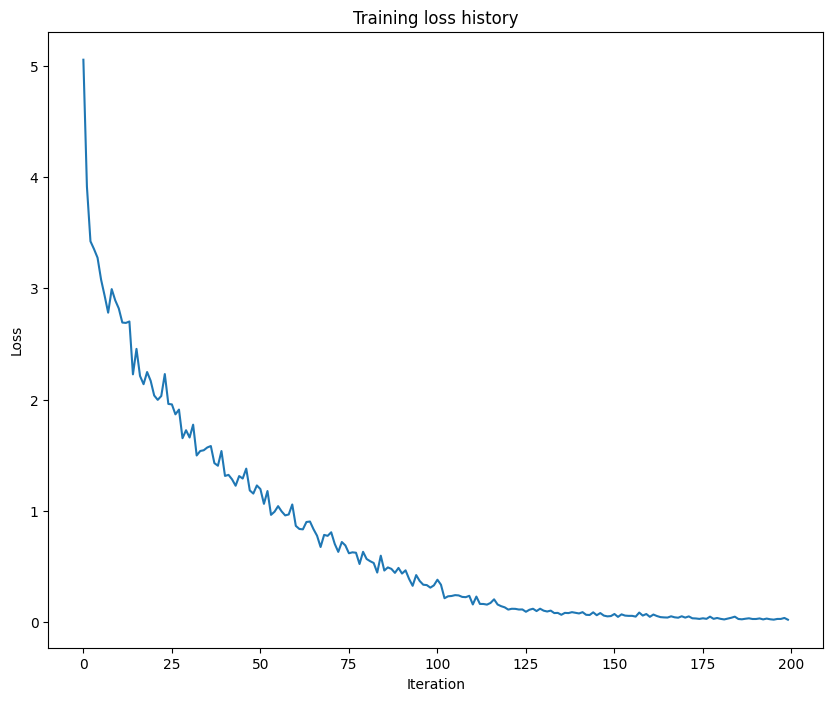

In [16]:
torch.manual_seed(231)
np.random.seed(231)

data = load_coco_data(max_train=50)

transformer = CaptioningTransformer(
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          wordvec_dim=256,
          num_heads=2,
          num_layers=2,
          max_length=30
        )


transformer_solver = CaptioningSolverTransformer(transformer, data, idx_to_word=data['idx_to_word'],
           num_epochs=100,
           batch_size=25,
           learning_rate=0.001,
           verbose=True, print_every=10,
         )

transformer_solver.train()

# Plot the training losses.
plt.plot(transformer_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

Print final training loss. You should see a final loss of less than 0.05 .

In [17]:
print('Final loss: ', transformer_solver.loss_history[-1])

Final loss:  0.02068659


# Transformer Sampling at Test Time
The sampling code has been written for you. You can simply run the following to compare with the previous results with the RNN. As before the training results should be much better than the validation set results, given how little data we trained on.

In [21]:
# If you get an error, the URL just no longer exists, so don't worry!
# You can re-sample as many times as you want.
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = transformer.sample(features, max_length=30)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        img = image_from_url(url)
        # Skip missing URLs.
        if img is None: continue
        plt.imshow(img)
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Vision Transformer (ViT)

[Dosovitskiy et. al.](https://arxiv.org/abs/2010.11929) showed that applying a transformer model on a sequence of image patches (referred to as Vision Transformer) not only achieves impressive performance but also scales more effectively than convolutional neural networks when trained on large datasets. We will build a version of Vision Transformer using our existing implementation of transformer components and train it on the CIFAR-10 dataset.

Vision Transformer converts input image into a sequence of patches of fixed size and embed each patch into a latent vector. In `cs231n/transformer_layers.py`, complete the implementation of `PatchEmbedding` and test it below. You should see relative error less than 1e-4.

In [10]:
from cs231n.transformer_layers import PatchEmbedding

torch.manual_seed(231)
np.random.seed(231)

N = 2
HW = 16
PS = 8
D = 8

patch_embedding = PatchEmbedding(
    img_size=HW,
    patch_size=PS,
    embed_dim=D
)

x = torch.randn(N, 3, HW, HW)
output = patch_embedding(x)


expected_output = np.asarray([
        [[-0.6312704 ,  0.02531429,  0.6112642 , -0.49089882,
          0.01412961, -0.6959372 , -0.32862484, -0.45402682],
        [ 0.18816411, -0.08142513, -0.9829535 , -0.23975623,
         -0.23109074,  0.97950286, -0.40997326,  0.7457837 ],
        [ 0.01810865,  0.15780598, -0.91804236,  0.36185235,
          0.8379501 ,  1.0191797 , -0.29667392,  0.20322265],
        [-0.18697818, -0.45137224, -0.40339014, -1.4381214 ,
         -0.43450755,  0.7651071 , -0.83683825, -0.16360264]],

       [[-0.39786366,  0.16201034, -0.19008337, -1.0602452 ,
         -0.28693503,  0.09791763,  0.26614824,  0.41781986],
        [ 0.35146567, -0.4469593 , -0.1841726 ,  0.45757473,
         -0.61304873, -0.29104248, -0.16124889, -0.14987172],
        [-0.2996967 ,  0.27353522, -0.09929767,  0.01973832,
         -1.2312065 , -0.6374332 , -0.22963578,  0.55696607],
        [-0.93818814,  0.02465284, -0.21117875,  1.1860403 ,
         -0.06137538, -0.21062079, -0.094347  ,  0.50032747]]])

print('error: ', rel_error(expected_output, output.detach().numpy()))

error:  9.182286955268188e-08


The sequence of patch vectors is processed by transformer encoder layers, each consisting of a self-attention and a feed-forward module. Since all vectors attend to one another, attention masking is not strictly necessary. However, we still implement it for the sake of consistency.

Implement `TransformerEncoderLayer` in `cs231n/transformer_layers.py` and test it below. You should see relative error less than 1e-6.


In [11]:
torch.manual_seed(231)
np.random.seed(231)

from cs231n.transformer_layers import TransformerEncoderLayer

N, T, TM, D = 1, 4, 5, 12

encoder_layer = TransformerEncoderLayer(D, 2, 4*D)
x = torch.randn(N, T, D)
x_mask = torch.randn(T, T) < 0.5

output = encoder_layer(x, x_mask)

expected_output = np.asarray([
    [[-0.43529928, -0.204897, 0.45693663, -1.1355408, 1.8000772,
      0.24467856, 0.8525885, -0.53586316, -1.5606489, -1.207276,
      1.3986266, 0.3266182],
     [0.06928468, 1.1030475, -0.9902548, -0.34333378, -2.1073136,
      1.1960536, 0.16573538, -1.1772276, 1.2644588, -0.27311313,
      0.29650143, 0.7961618],
     [0.28310525, 0.69066685, -1.2264299, 1.0175265, -2.0517688,
     -0.10330413, -0.5355796, -0.2696466, 0.13948536, 2.0408154,
      0.27095756, -0.25582793],
     [-0.58568114, 0.8019579, -0.9128079, -1.6816932, 1.1572194,
      0.39162305, 0.58195484, 0.7043353, -1.27042, -1.1870497,
      0.9784279, 1.0221335]]
])

print('error: ', rel_error(expected_output, output.detach().numpy()))

error:  6.809801002433283e-07


Take a look at the `VisionTransformer` implementation in `cs231n/classifiers/transformer.py`.

For classification, ViT divides the input image into patches and processes the sequence of patch vectors using a transformer. Finally, all the patch vectors are average-pooled and used to predict the image class. We will use the same 1D sinusoidal positional encoding to inject ordering information, though 2D sinusoidal and learned positional encodings are also valid choices.

Complete the ViT forward pass and test it below. You should see relative error less than 1e-6.

In [19]:
torch.manual_seed(231)
np.random.seed(231)
from cs231n.classifiers.transformer import VisionTransformer

imgs = torch.randn(3, 3, 32, 32)
transformer = VisionTransformer()
scores = transformer(imgs)
expected_scores = np.asarray(
    [[-0.13013132,  0.13652277, -0.04656096, -0.16443546, -0.08946665,
        -0.10123537,  0.11047452,  0.01317241,  0.17256221,  0.16230097],
       [-0.11988413,  0.20006064, -0.04028708, -0.06937674, -0.07828291,
        -0.13545093,  0.18698244,  0.01878054,  0.14309685,  0.03245382],
       [-0.11540816,  0.21416159, -0.07740889, -0.08336161, -0.1645808 ,
        -0.12318538,  0.18035144,  0.05492767,  0.15997584,  0.12134959]])
print('scores error: ', rel_error(expected_scores, scores.detach().numpy()))

scores error:  1.1475049635665582e-06



We will first verify our implementation by overfitting it on one training batch. Tune learning rate and weight decay accordingly.

In [47]:
from torchvision import transforms
from torchvision.datasets import CIFAR10
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

train_data = CIFAR10(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_data = CIFAR10(root='data', train=False, transform=transforms.ToTensor(), download=True)

100%|██████████| 170M/170M [00:08<00:00, 21.3MB/s] 


In [23]:

learning_rate = 1e-3
weight_decay = 1.e-3


batch = next(iter(DataLoader(train_data, batch_size=64, shuffle=False)))
model = VisionTransformer(dropout=0.0)
loss_criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
model.train()

epochs = 100
for epoch in range(epochs):
    imgs, target = batch
    out = model(imgs)
    loss = loss_criterion(out, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    top1 = (out.argmax(-1) == target).float().mean().item()
    if epoch % 10 == 0:
      print(f"[{epoch}/{epochs}] Loss {loss.item():.6f}, Top-1 Accuracy: {top1:.3f}")


[0/100] Loss 2.330371, Top-1 Accuracy: 0.078
[10/100] Loss 2.108550, Top-1 Accuracy: 0.188
[20/100] Loss 1.957598, Top-1 Accuracy: 0.281
[30/100] Loss 1.807407, Top-1 Accuracy: 0.250
[40/100] Loss 1.611219, Top-1 Accuracy: 0.422
[50/100] Loss 1.210909, Top-1 Accuracy: 0.578
[60/100] Loss 1.119390, Top-1 Accuracy: 0.562
[70/100] Loss 0.705269, Top-1 Accuracy: 0.828
[80/100] Loss 0.377919, Top-1 Accuracy: 0.969
[90/100] Loss 0.146742, Top-1 Accuracy: 0.984


In [24]:
# You should get perfect 1.00 accuracy
print(f"Overfitting ViT on one batch. Top-1 accuracy: {top1}")

Overfitting ViT on one batch. Top-1 accuracy: 1.0


Now we will train it on the entire dataset.

In [51]:
from cs231n.classification_solver_vit import ClassificationSolverViT
from cs231n.classifiers.transformer import VisionTransformer

############################################################################
# TODO: Train a Vision Transformer model that achieves over 0.45 test      #
# accuracy on CIFAR-10 after 2 epochs by adjusting the model architecture  #
# and/or training parameters as needed.                                    #
#                                                                          #
# Note: If you want to use a GPU runtime, go to `Runtime > Change runtime  #
# type` and set `Hardware accelerator` to `GPU`. This will reset Colab,    #
# so make sure to rerun the entire notebook from the beginning afterward.  #
############################################################################

learning_rate = 9e-4
weight_decay = 1e-10
batch_size = 32
model = VisionTransformer(num_heads=16,num_layers=8)

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

solver = ClassificationSolverViT(
    train_data=train_data,
    test_data=test_data,
    model=model,
    num_epochs = 2,  # Don't change this
    learning_rate = learning_rate,
    weight_decay = weight_decay,
    batch_size = batch_size,
)

solver.train('cuda' if torch.cuda.is_available() else 'cpu')



Test Epoch: [1/2] Loss: 1.5226 ACC@1: 0.451%: 100%|██████████| 313/313 [00:02<00:00, 133.67it/s]


In [52]:
print(f"Accuracy on test set: {solver.results['best_test_acc']}")

Accuracy on test set: 0.4509


# Inline Question 2

Despite their recent success in large-scale image recognition tasks, ViTs often lag behind traditional CNNs when trained on smaller datasets. What underlying factor contribute to this performance gap? What techniques can be used to improve the performance of ViTs on small datasets?

**Your Answer**:


ViTs lack the inductive biases inherent in CNNs, such as translation equivariance and locality; it also flattens the image into patches, losing some spatial information.

to improve performance on small datasets, we can pretrain on large datasets, apply regularization or even use a Vit mixed with CNN.



# Inline Question 3

How does the computational cost of the self-attention layers in a ViT change if we independently make the following changes? Please ignore the computation cost of QKV and output projection.

(i) Double the hidden dimension.

(ii) Double the height and width of the input image.

(iii) Double the patch size.

(iv) Double the number of layers.


**Your Answer**:

Self-attention has $O(n^2d)$ complexity, where n is the sequence length $n = \dfrac{H \times W}{P^2}$ and d is the hidden dimension, so:

1. 2x
2. 16x
3. 1/16x
4. 2x